<a href="https://colab.research.google.com/github/alamjane/Walmart-Sales-Prediction/blob/main/Walmart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Walmart's Weekly Sales Analysis and Prediction**

In [21]:
# importing data analysis libraries
import numpy as np
import pandas as pd

# importing visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
# overriding matplotlib 
sns.set()

# import datetime
import datetime as dt

# import the preprocessing classes
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# import train/test split module
from sklearn.model_selection import train_test_split

# import the regressors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

# import metrics
from sklearn.metrics import mean_squared_error

# import warnings
import warnings 
warnings.filterwarnings('ignore')

In [22]:
# load the dataset
sales = pd.read_csv('/content/walmart.csv')
sales.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [23]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [24]:
# convert Date column data type to date-time
sales['Date'] = pd.to_datetime(sales.Date)

In [25]:
# check 
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [26]:
# convert column names to lower case
sales.columns = [col.lower() for col in sales.columns ]

In [27]:
# check
sales.columns 

Index(['store', 'date', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment'],
      dtype='object')

In [28]:
# check duplicates
sales[sales.duplicated()]

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment


In [29]:
def find_outlier_rows(df, col, level='both'):
    """
    Finds the rows with outliers in a given column of a dataframe.

    This function takes a dataframe and a column as input, and returns the rows
    with outliers in the given column. Outliers are identified using the
    interquartile range (IQR) formula. The optional level parameter allows the
    caller to specify the level of outliers to return, i.e., lower, upper, or both.

    Args:
        df: The input dataframe.
        col: The name of the column to search for outliers.
        level: The level of outliers to return, i.e., 'lower', 'upper', or 'both'.
               Defaults to 'both'.

    Returns:
        A dataframe containing the rows with outliers in the given column.
    """
    # compute the interquartile range
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)

    # compute the upper and lower bounds for identifying outliers
    lower_bound = df[col].quantile(0.25) - 1.5 * iqr
    upper_bound = df[col].quantile(0.75) + 1.5 * iqr

    # filter the rows based on the level of outliers to return
    if level == 'lower':
        return df[df[col] < lower_bound]
    elif level == 'upper':
        return df[df[col] > upper_bound]
    else:
        return df[(df[col] > upper_bound) | (df[col] < lower_bound)]

In [30]:
def count_outliers(df):
    """
    This function takes in a DataFrame and returns a DataFrame containing the count and 
    percentage of outliers in each numeric column of the original DataFrame.

    Input:
        df: a Pandas DataFrame containing numeric columns

    Output:
        a Pandas DataFrame containing two columns:
        'outlier_counts': the number of outliers in each numeric column
        'outlier_percent': the percentage of outliers in each numeric column
    """
    # select numeric columns
    df_numeric = df.select_dtypes(include=['int', 'float'])

    # get column names
    columns = df_numeric.columns

    # find the name of all columns with outliers
    outlier_cols = [col for col in columns if len(find_outlier_rows(df_numeric, col)) != 0]

    # dataframe to store the results
    outliers_df = pd.DataFrame(columns=['outlier_counts', 'outlier_percent'])

    # count the outliers and compute the percentage of outliers for each column
    for col in outlier_cols:
        outlier_count = len(find_outlier_rows(df_numeric, col))
        all_entries = len(df[col])
        outlier_percent = round(outlier_count * 100 / all_entries, 2)

        # store the results in the dataframe
        outliers_df.loc[col] = [outlier_count, outlier_percent]

    # return the resulting dataframe
    return outliers_df


In [31]:
# count the outliers in sales dataframe
count_outliers(sales).sort_values('outlier_counts', ascending=False)

,outlier_counts,outlier_percent
unemployment,481.0,7.47
holiday_flag,450.0,6.99
weekly_sales,34.0,0.53
temperature,3.0,0.05


In [32]:
# view the summary statistics of unemployment rate
find_outlier_rows(sales, 'unemployment')['unemployment'].describe()

count    481.000000
mean      11.447480
std        3.891387
min        3.879000
25%       11.627000
50%       13.503000
75%       14.021000
max       14.313000
Name: unemployment, dtype: float64

In [33]:
find_outlier_rows(sales, 'holiday_flag')['holiday_flag'].describe()

count    450.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: holiday_flag, dtype: float64

In [34]:
# find the outliers in weekly sales
find_outlier_rows(sales, 'weekly_sales')

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment
189,2,2010-12-24,3436007.68,0,49.97,2.886,211.064660,8.163
241,2,2011-12-23,3224369.80,0,46.66,3.112,218.999550,7.441
471,4,2010-11-26,2789469.45,1,48.08,2.752,126.669267,7.127
474,4,2010-12-17,2740057.14,0,46.57,2.884,126.879484,7.127
475,4,2010-12-24,3526713.39,0,43.21,2.887,126.983581,7.127
523,4,2011-11-25,3004702.33,1,47.96,3.225,129.836400,5.143
526,4,2011-12-16,2771397.17,0,36.44,3.149,129.898065,5.143
527,4,2011-12-23,3676388.98,0,35.92,3.103,129.984548,5.143
761,6,2010-12-24,2727575.18,0,55.07,2.886,212.916508,7.007
1329,10,2010-11-26,2939946.38,1,55.33,3.162,126.669267,9.003


In [35]:
# calculate the employment rate
sales['employment'] = 100 - sales['unemployment']

In [36]:
# split the date column
sales['year']= sales['date'].dt.year
sales['month'] = sales['date'].dt.month
sales['day'] = sales['date'].dt.day
sales.head(3)

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,employment,year,month,day
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,91.894,2010,5,2
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,91.894,2010,12,2
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,91.894,2010,2,19


In [37]:
# get the summary statisitcs of the datset
sales.describe()

,store,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,employment,year,month,day
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,92.000849,2010.965035,6.475524,15.650350
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,1.875885,0.797019,3.321797,8.753908
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,85.687000,2010.000000,1.000000,1.000000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,91.378000,2010.000000,4.000000,8.000000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,92.126000,2011.000000,6.000000,16.000000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,93.109000,2012.000000,9.000000,23.000000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,96.121000,2012.000000,12.000000,31.000000


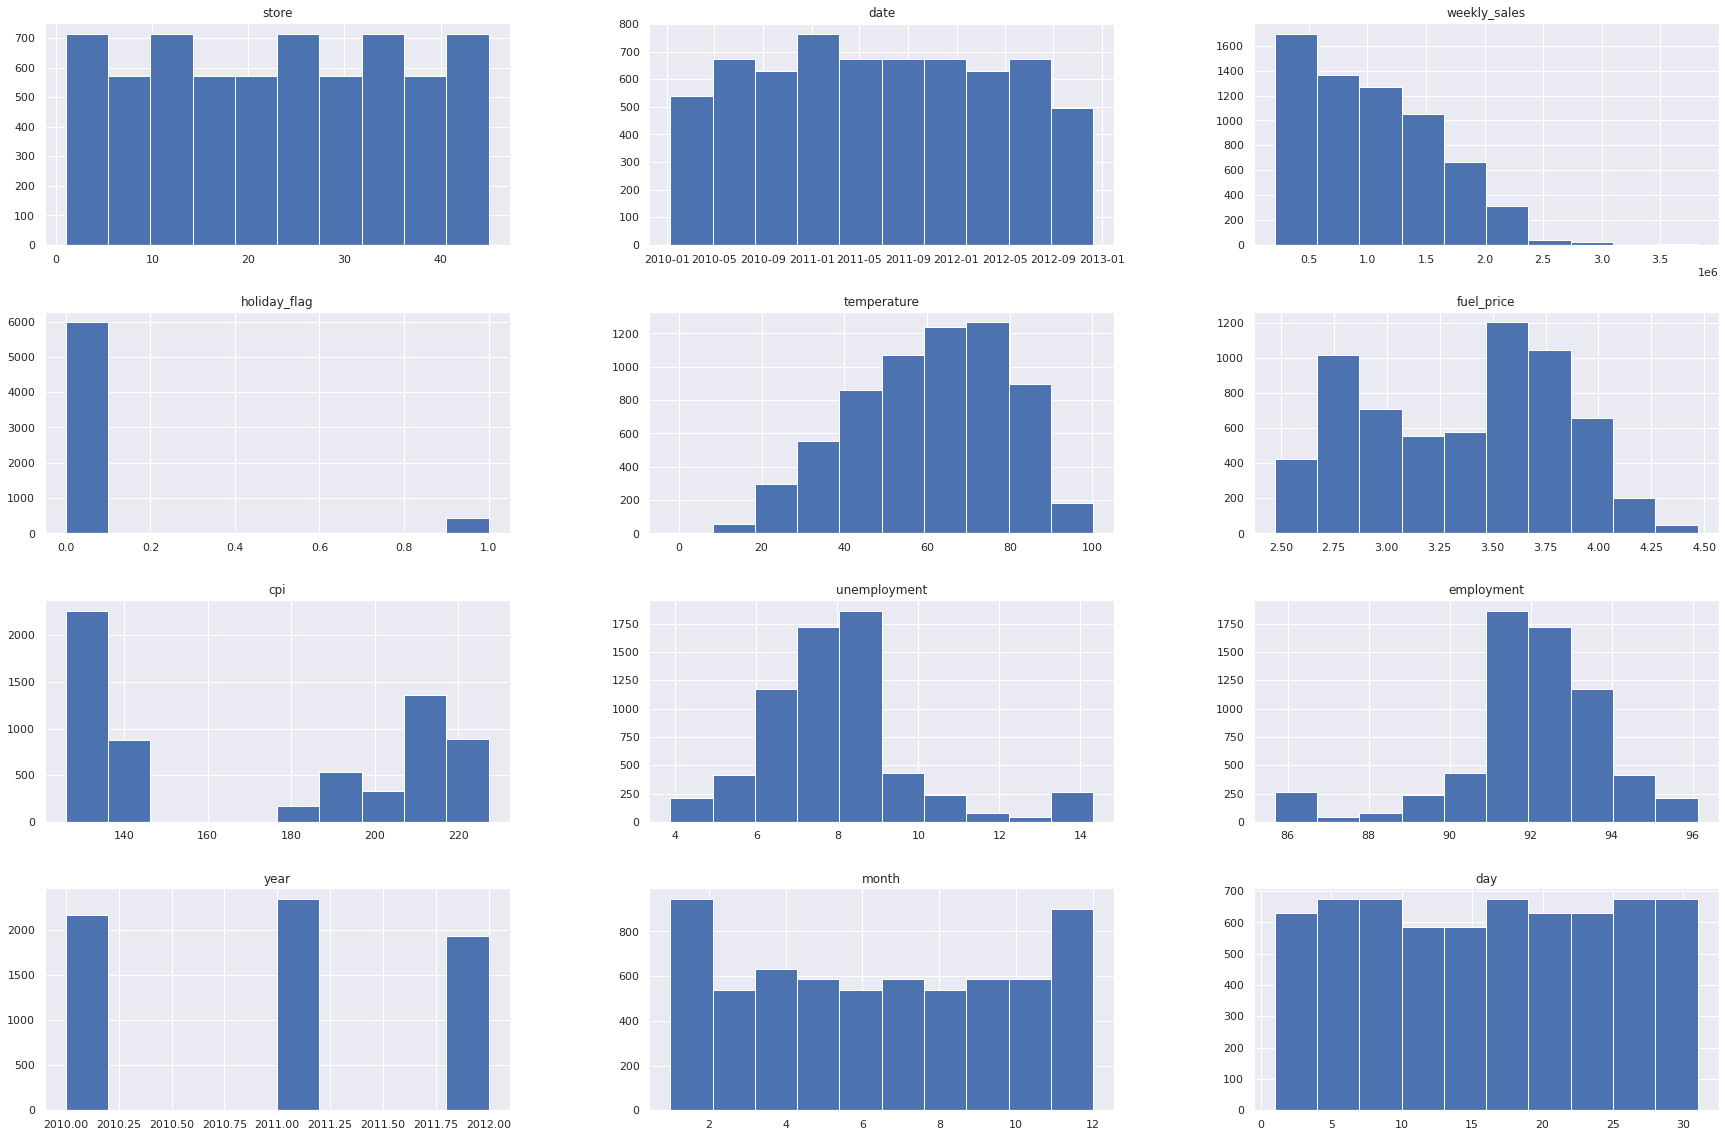

In [38]:
# histograms
sales.hist(figsize=(30,20));

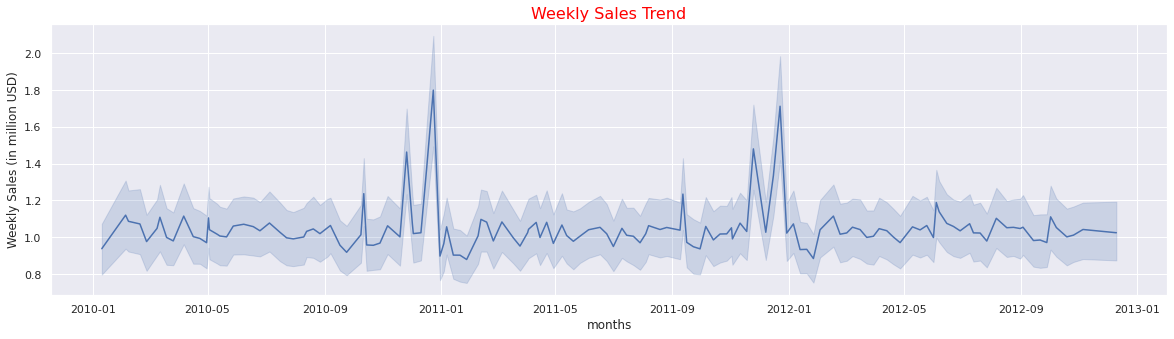

In [39]:
# plot the line chart of the weekly_sales
fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(x=sales.date, y=(sales.weekly_sales/1e6))
plt.xlabel('months')
plt.ylabel('Weekly Sales (in million USD)')
plt.title('Weekly Sales Trend',fontdict={'fontsize': 16, 'color':'red'}, pad=5)

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

plt.show()

**The line plot reveals that weekly sales at Walmart generally remain stable throughout the year, with the exception of November and December, which experience a significant increase in sales. This trend is likely due to the holiday season, when consumers typically make more purchases and retailers offer promotions and discounts. To capitalize on this behavior, Walmart could consider offering seasonal discounts and promotions, as well as ensuring a seamless and enjoyable shopping experience through their mobile and web outlets during festive periods. By doing so, they can encourage more customers to make purchases and potentially drive up sales.**

---

\

In [40]:
# create the pivot table
pivot_table = sales.pivot_table(index='month', columns='year', values='weekly_sales')
# display the pivot table
pivot_table

year,2010,2011,2012
month,,,
1,9.386639e+05,9.420697e+05,9.567817e+05
2,1.064372e+06,1.042273e+06,1.057997e+06
3,1.034590e+06,1.011263e+06,1.025510e+06
4,1.021177e+06,1.033220e+06,1.014127e+06
5,1.039303e+06,1.015565e+06,1.053948e+06
6,1.055082e+06,1.038471e+06,1.082920e+06
7,1.023702e+06,9.976049e+05,1.025480e+06
8,1.025212e+06,1.044895e+06,1.064514e+06
9,9.983559e+05,1.026810e+06,9.988663e+05


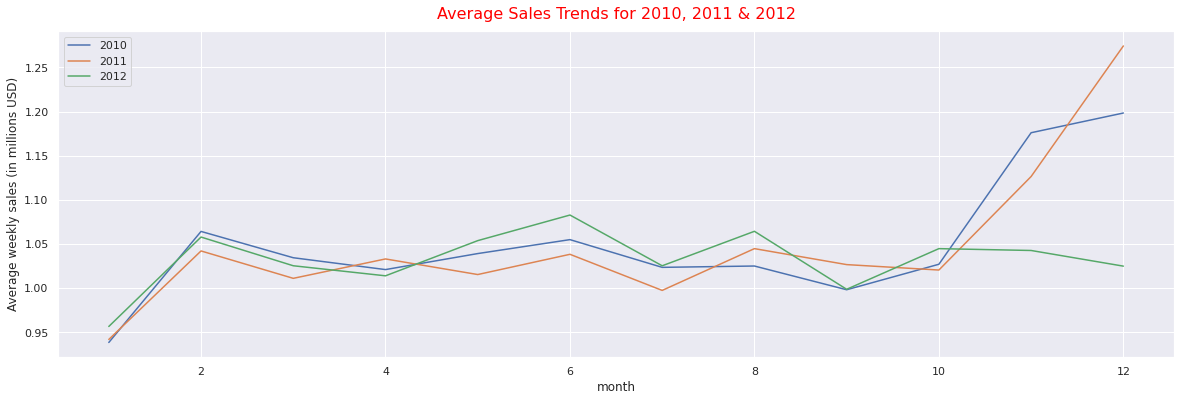

In [41]:
# plot the average sales
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_palette("bright")
sns.lineplot(x=pivot_table.index, y=pivot_table[2010]/1e6, ax=ax, label='2010')
sns.lineplot( x=pivot_table.index, y=pivot_table[2011]/1e6, ax=ax, label='2011')
sns.lineplot( x=pivot_table.index, y=pivot_table[2012]/1e6, ax=ax, label='2012')
plt.ylabel('Average weekly sales (in millions USD)')
plt.title('Average Sales Trends for 2010, 2011 & 2012', fontdict ={'fontsize':16,
                                                                   'color':'red',
                                                                   'horizontalalignment': 'center'},
                                                                   pad=12)
# Add a legend
plt.legend()
plt.show()

We can observe that the line charts for the three years for the month of January to October simultaneously follow a sawtooth shape with big rises experienced in November and December due to holidays. This indicates seasonality trends as months do have consistencies in bigger or smaller sales for the three years. We can also observe that although 2011 performed worst than 2010 in terms of average sales for Walmart, the trend was reversed for the year 2012 which performed better than 2010. However, the data for 2012 ends in October, which may explain the significant drop in sales for November."

In [42]:
def plot_top_and_bottom_stores(df, col):
    """
    Plot the top and bottom 5 stores based on their average weekly sales.
    
    Parameters:
    df (pandas DataFrame): The dataframe containing the sales data.
    col (str): The name of the column to group the data by.
    
    Returns:
    None
    """
    # Group the data by the specified column and sort it by sales in descending order
    df = df.groupby(col).mean().sort_values(by='weekly_sales', ascending=False)
    
    # Select the top 5 and bottom 5 products
    top_stores = df.head(5)
    bottom_stores = df.tail(5)
    
    # Set the color palette
    sns.set_palette("bright")
    
    # Create a bar chart of the top 5 products
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=top_stores.index, y=top_stores['weekly_sales']/1e6, order=top_stores.index)
    plt.title('Top 5 Stores by Average Sales')
    plt.ylabel('Average weekly sales (millions USD)')
    plt.show()
    
    # Create a bar chart of the bottom 5 products
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=bottom_stores.index, y=bottom_stores['weekly_sales']/1e6, order=bottom_stores.index)
    plt.title('Bottom 5 Stores by Average Sales')
    plt.ylabel('Average weekly sales (millions USD)')
    plt.show()

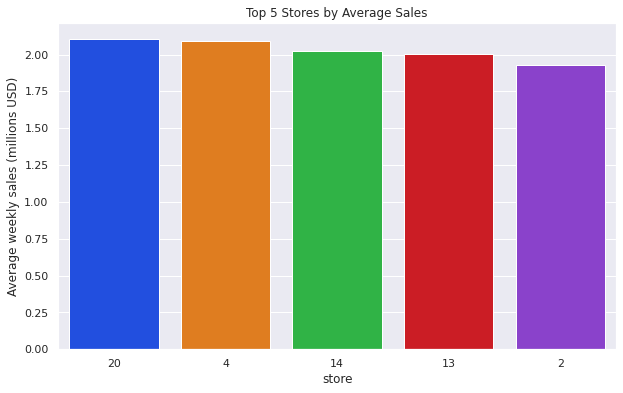

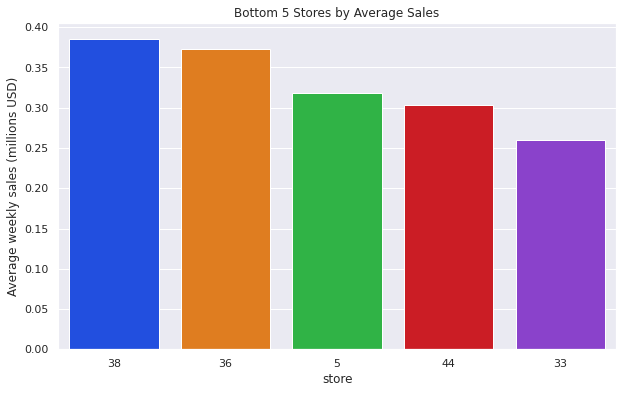

In [43]:
plot_top_and_bottom_stores(sales, 'store')

The graphs show that the top performing stores have relatively stable sales with an average of around $2 million USD. Store 20 appears to be the top performer among these stores, with relatively little variation in sales compared to the other top performers.

On the other hand, the lowest performing stores have higher variations in sales, with the highest sales at around $0.38 million USD. This suggests that there may be more variability in the sales performance of these stores.

In [44]:
# filter out non-holiday and holiday weekly sales 
non_holiday_sales = sales[sales['holiday_flag'] == 0]
holiday_sales = sales[sales['holiday_flag'] == 1]

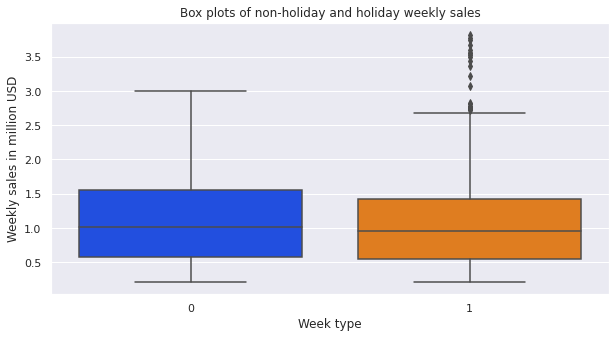

In [45]:
# plot box plots of non-holiday and holiday weekly sales 
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=[holiday_sales['weekly_sales']/1e6, non_holiday_sales['weekly_sales']/1e6])
plt.ylabel('Weekly sales in million USD')
plt.xlabel('Week type')
plt.title('Box plots of non-holiday and holiday weekly sales')
plt.show()

We can see that both holiday and non-holiday weekly sales have similar spread. However, the bigger sales happen during the holiday weeks

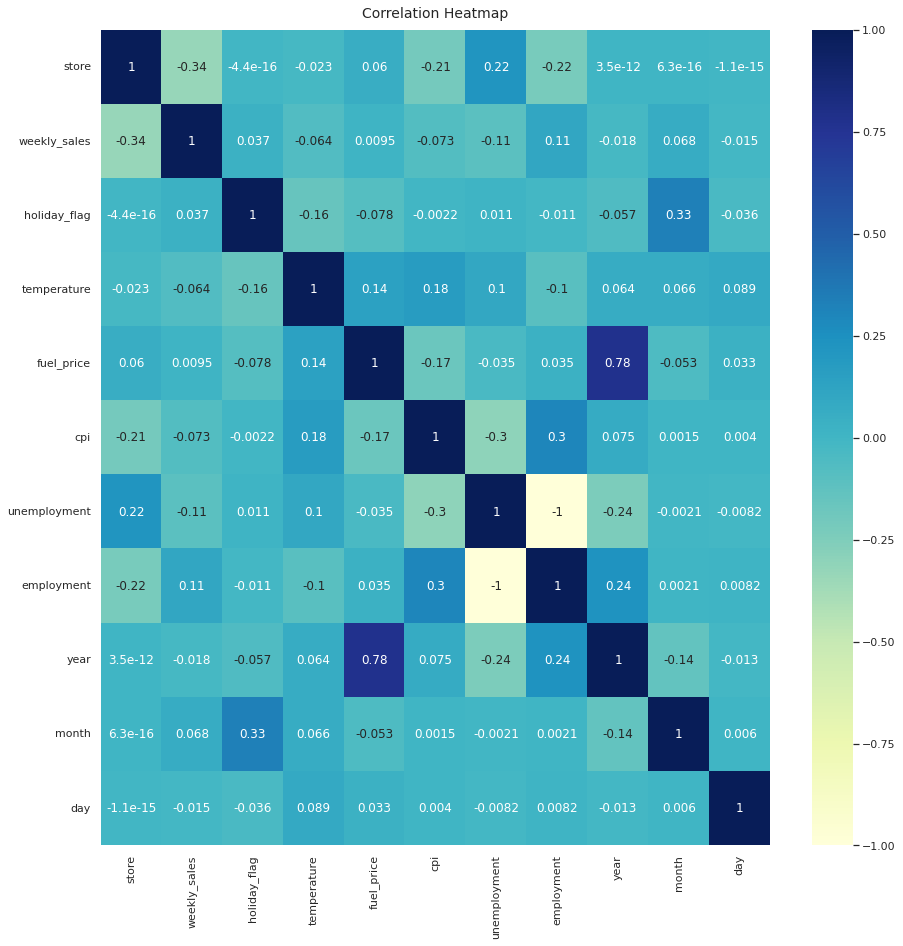

In [46]:
fig, ax = plt.subplots(figsize=(15,15))
heatmap = sns.heatmap(sales.corr(), vmin=-1, vmax=1, annot=True, cmap ="YlGnBu")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

Of all the weaker correlations, employment is the strongest with 0.11 correlation coefficient

In [47]:
# make a copy of the dataset
sales_copy = sales.copy()

In [48]:
# drop the date and unemployment columns
sales_copy.drop(['date', 'unemployment'], axis=1, inplace=True)
# check
sales_copy.head()

,store,weekly_sales,holiday_flag,temperature,fuel_price,cpi,employment,year,month,day
0,1,1643690.90,0,42.31,2.572,211.096358,91.894,2010,5,2
1,1,1641957.44,1,38.51,2.548,211.242170,91.894,2010,12,2
2,1,1611968.17,0,39.93,2.514,211.289143,91.894,2010,2,19
3,1,1409727.59,0,46.63,2.561,211.319643,91.894,2010,2,26
4,1,1554806.68,0,46.50,2.625,211.350143,91.894,2010,5,3


In [49]:
X = sales_copy.drop('weekly_sales', axis=1)
y = sales_copy['weekly_sales']

In [50]:
# scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [51]:
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=50)

In [52]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluate a model on training and test data.

    Parameters
    ----------
    model : object
        A scikit-learn estimator object.
    X_train : array-like or pd.DataFrame
        Training data with shape (n_samples, n_features).
    y_train : array-like
        Training labels with shape (n_samples,).
    X_test : array-like or pd.DataFrame
        Test data with shape (n_samples, n_features).
    y_test : array-like
        Test labels with shape (n_samples,).

    Returns
    -------
    rmse : float
        Root mean squared error between the test labels and the predictions.
    """
    # train
    model.fit(X_train, y_train)
    # predict
    y_pred = model.predict(X_test)
    # calculate MSE
    mse = mean_squared_error(y_test, y_pred)
    # calculate RMSE
    rmse = np.sqrt(mse)
    return rmse

In [53]:
def evaluate_regressors_rmses(regressors, regressor_names, X_train, y_train, X_test, y_test):
    """
    This function takes a list of regressors, their names, and the training and test data as input
    and returns a dataframe with the names of the regressors and their root mean squared error (RMSE)
    on the test data.
    
    Parameters:
    -----------
    regressors (list): a list of scikit-learn compatible regression models
    regressor_names (list): a list of strings containing the names of the regression models
    X_train (pandas DataFrame): a pandas DataFrame containing the features for training the models
    y_train (pandas Series): a pandas Series containing the target values for training the models
    X_test (pandas DataFrame): a pandas DataFrame containing the features for testing the models
    y_test (pandas Series): a pandas Series containing the target values for testing the models
    
    Returns:
    --------
    pandas DataFrame: a dataframe containing the names of the regressors and their corresponding RMSE on the test data
    """
    
    # evaluate the models and compute their RMSE on the test data
    rmses = [evaluate_model(regressor, X_train, y_train, X_test, y_test) for regressor in regressors]
    
    # create a dictionary mapping the names of the regressors to their RMSE
    regressor_rmses = dict(zip(regressor_names, rmses))
    
    # convert the dictionary to a pandas dataframe
    df = pd.DataFrame.from_dict(regressor_rmses, orient='index')
    
    # reset the index of the dataframe
    df = df.reset_index()
    
    # rename the columns of the dataframe
    df.columns = ['regressor_name', 'rmse']
    
    # sort the dataframe by RMSE in ascending order
    return df.sort_values('rmse', ignore_index=True)

In [54]:
# initialize the regressors
linear_regressor = LinearRegression()
polynomial_features = PolynomialFeatures(degree=2)
polynomial_regressor = Pipeline([("polynomial_features", polynomial_features),
("linear_regression", linear_regressor)])
ridge_regressor = Ridge()
lasso_regressor = Lasso()
elastic_net_regressor = ElasticNet()
decision_tree_regressor = DecisionTreeRegressor()
random_forest_regressor = RandomForestRegressor()
boosted_tree_regressor = GradientBoostingRegressor()
neural_network_regressor = MLPRegressor()
support_vector_regressor = SVR()
grad_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, loss='ls')
knn_regressor = KNeighborsRegressor(n_neighbors=5, weights='uniform')
spline_regressor = make_pipeline(PolynomialFeatures(3), LinearRegression())

In [55]:
# collect the list of regressors
regressors = [linear_regressor, polynomial_regressor, ridge_regressor, lasso_regressor, elastic_net_regressor, 
              decision_tree_regressor, random_forest_regressor, boosted_tree_regressor, neural_network_regressor, 
              support_vector_regressor, knn_regressor, spline_regressor]

# collect the names of regressors
regressor_names = ["Linear Regression", "Polynomial Regression", "Ridge Regression", "Lasso Regression", 
                   "Elastic Net Regression", "Decision Tree Regression", "Random Forest Regression", 
                   "Boosted Tree Regression", "Neural Network Regression", "Support Vector Regression", 
                   "K-Nearest Neighbour Regression", "Spline Regression"]

In [56]:
print('\033[1m Table of regressors and their RMSEs')
evaluate_regressors_rmses(regressors, regressor_names, X_train, y_train, X_test, y_test)

 Table of regressors and their RMSEs


,regressor_name,rmse
0,Random Forest Regression,1.169368e+05
1,Decision Tree Regression,1.490412e+05
2,Boosted Tree Regression,1.750082e+05
3,Spline Regression,4.376419e+05
4,K-Nearest Neighbour Regression,4.606521e+05
5,Polynomial Regression,4.786478e+05
6,Ridge Regression,5.209623e+05
7,Lasso Regression,5.209627e+05
8,Linear Regression,5.209628e+05
9,Elastic Net Regression,5.258987e+05


In [57]:
# evaluate rmse for the regressors
rmse = evaluate_regressors_rmses(regressors, regressor_names, X_train, y_train, X_test, y_test)
# pick the best rmse
best_rmse = rmse.iloc[0]['rmse']
# compute the median of the weekly sales 
median_sale = sales['weekly_sales'].median()
# compute percentage error
percent_deviation = round((best_rmse*100/median_sale), 2)
# print the result
print('The model has average percentage error of {}%'.format(percent_deviation))

The model has average percentage error of 12.14%


Conclusions

Our analysis shows that sales during holiday weeks are significantly higher than during non-holiday weeks, with sales doubling on average. Additionally, there is a strong seasonal component to the sales data. The average sales of the top performing stores are up to 500% higher than the lowest performing stores.

The best model for predicting future sales is the Random Forest Regressor model,which achieved an RMSE of 1.17e+05. This is a good estimate as it is 88% close to the median sale of the data.

These findings have important implications for businesses as they can inform decisions about inventory, staffing, and marketing efforts. By understanding the factors that drive sales and using a reliable model to forecast future sales, businesses can better plan for the future and optimize their resources.

Future work